# April Tag Tracker
use this notebook track the location of april tagged nodes in a video and output a csv containing the position and angles of each node

In [2]:
# Imports
import cv2
# import apriltag
import numpy as np
from matplotlib import pyplot as plt
import ffmpeg
from pupil_apriltags import Detector
# import opencv_jupyter_ui as jcv2
# from google.colab.patches import cv2_imshow
import os
import re
import glob
import pandas as pd
import gc
from scipy.signal import medfilt, savgol_filter
import ast
import time
import xml.etree.ElementTree as ET
from scipy.signal import find_peaks

import ipywidgets as widgets
from pathlib import Path
from IPython.display import display, clear_output

from matplotlib import rcParams

rcParams['animation.ffmpeg_path'] = '/opt/miniconda3/envs/tplax_env/bin/ffmpeg'

dist_coeffs = np.array([-3.77932235e-01,  1.81918585e-01, -9.30045382e-05, 
                        -2.08242888e-03,  -4.90966330e-02])
camera_matrix = np.array([[1.54009298e+03, 0.00000000e+00, 9.58442344e+02],
                         [0.00000000e+00, 1.54227003e+03, 1.00722240e+03],
                         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
tag_size = 0.035 
tag_size_corner = 0.05

env_corners = [(244,215) , (1757,270) , (1702,1780) , (195,1735)]

%matplotlib inline

In [35]:
# Function Defs
def annotate_tags(image, results, camera_matrix=camera_matrix, dist_coeffs=dist_coeffs,
                  hamming_cutoff = 1, plot_distance = False):
    # Draw results and calculate distances
    df = pd.DataFrame(columns=['Frame#', 'id', 'x', 'y', 'dist', 'rot', 'hamming'])
    for r in results:
        if r.hamming <= hamming_cutoff:
            (ptA, ptB, ptC, ptD) = r.corners
            ptA = tuple(map(int, ptA))
            ptB = tuple(map(int, ptB))
            ptC = tuple(map(int, ptC))
            ptD = tuple(map(int, ptD))

            # Draw bounding box
            cv2.line(image, ptA, ptB, (0, 255, 0), 2)
            cv2.line(image, ptB, ptC, (0, 255, 0), 2)
            cv2.line(image, ptC, ptD, (0, 255, 0), 2)
            cv2.line(image, ptD, ptA, (0, 255, 0), 2)

            # Draw the center
            center = tuple(map(int, r.center))
            cv2.circle(image, center, 5, (0, 0, 255), -1)
            cv2.putText(image, f"ID: {r.tag_id}", center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Pose estimation (distance calculation)
            obj_points = np.array([
                [-tag_size / 2, -tag_size / 2, 0],  # Bottom-left corner
                [ tag_size / 2, -tag_size / 2, 0],  # Bottom-right corner
                [ tag_size / 2,  tag_size / 2, 0],  # Top-right corner
                [-tag_size / 2,  tag_size / 2, 0]   # Top-left corner
            ], dtype=np.float32)

            img_points = np.array(r.corners, dtype=np.float32)

            # Solve PnP (Perspective-n-Point) to find pose

            success, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_matrix, dist_coeffs)
            if success:
                # tvec contains the translation vector, where tvec[2] is the distance
                distance = tvec[2][0]
                print(f"Tag ID: {r.tag_id}, Distance: {distance:.3f} meters")
                if plot_distance:
                    # Annotate the image with the distance
                    cv2.putText(image, f"Distance: {distance:.2f} m", (center[0], center[1] + 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                
    return image #, success, rvec, tvec

def track_tags(video_path, detector, camera_matrix=camera_matrix, 
                  dist_coeffs=dist_coeffs, plot_distance = False, 
                  output_path=None):
    """
    Take video and on a frame by frame basis identify tags
    """
    df = pd.DataFrame(columns=['Frame#', 'id', 'x', 'y', 'dist', 'rot', 'hamming'])
    
    # Ensure input video exists
    if not os.path.exists(video_path):
        print(f"Error: Input video not found at {video_path}")
        return
    
    # Open video capture
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create video writer if output path is specified
    if output_path:
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
        print(f"Writing output to: {os.path.abspath(output_path)}")
    
    frame_count = 0
    while cap.isOpened() and frame_count < total_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # convert to gray and detect tags    
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        tags = at_detector.detect(image)
        
        image = annotate_tags(image, tags)
        
                
        
        # Display current frame number
        frame_count += 1
        print(f"Processing frame {frame_count}/{total_frames}")
        
        # Write frame if output path is specified
        if output_path:
            out.write(image)
    
    # Release resources
    cap.release()
    if output_path:
        out.release()
        print(f"Processing complete. Output video saved to: {os.path.abspath(output_path)}")

def get_pose(corners, tag_size = 0.035,
             camera_matrix=camera_matrix, dist_coeffs=dist_coeffs):
    ptA, ptB, ptC, ptD = corners[0]
    ptA = tuple(map(int, ptA))
    ptB = tuple(map(int, ptB))
    ptC = tuple(map(int, ptC))
    ptD = tuple(map(int, ptD))

    # Pose estimation (distance calculation)
    obj_points = np.array([
        [-tag_size / 2, -tag_size / 2, 0],  # Bottom-left corner
        [ tag_size / 2, -tag_size / 2, 0],  # Bottom-right corner
        [ tag_size / 2,  tag_size / 2, 0],  # Top-right corner
        [-tag_size / 2,  tag_size / 2, 0]   # Top-left corner
    ], dtype=np.float32)

    img_points = np.array([ptA,ptB,ptC,ptD], dtype=np.float32)

    # Solve PnP (Perspective-n-Point) to find pose

    success, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_matrix, dist_coeffs, flags = cv2.SOLVEPNP_IPPE)
    
    return success, rvec, tvec

# Track Interpolation Functions


def interpolate_tracks(df, max_timesteps=1000):
    """
    Interpolate missing timesteps in particle tracks, maintaining existing data
    and only filling gaps with increments of 1.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing particle tracks with columns 
                      ['node_id', 'frame#', 'x', 'y', 'z', 'angle']
    max_timesteps (int): Maximum number of timesteps expected (0 to max_timesteps-1)
    
    Returns:
    pd.DataFrame: DataFrame with interpolated tracks
    """
    # Create a list to store interpolated data for each particle
    interpolated_data = []
    
    # Get unique particle IDs
    particle_ids = df['node_id'].unique()
    
    # Process each particle
    for particle_id in particle_ids:
        # Get data for this particle
        particle_data = df[df['node_id'] == particle_id].copy()
        
        # Create a DataFrame with all timesteps from 0 to max_timesteps-1
        all_timesteps = pd.DataFrame({
            'frame#': range(max_timesteps),
            'node_id': particle_id
        })
        
        # Merge with actual data
        merged = pd.merge(all_timesteps, particle_data, 
                         on=['node_id', 'frame#'], 
                         how='left')
        
        # Interpolate missing values
        merged['x'] = merged['x'].interpolate(method='linear', limit_direction='both')
        merged['y'] = merged['y'].interpolate(method='linear', limit_direction='both')
        merged['z'] = merged['z'].interpolate(method='linear', limit_direction='both')
        merged['angle'] = merged['angle'].interpolate(method='linear', limit_direction='both')
        
#         # Only keep rows between first and last actual measurements
#         first_measurement = particle_data['timestamp'].min()
#         last_measurement = particle_data['timestamp'].max()
#         merged = merged[
#             (merged['timestamp'] >= first_measurement) & 
#             (merged['timestamp'] <= last_measurement)
#         ]
        
        interpolated_data.append(merged)
    
    # Combine all interpolated tracks
    interpolated_df = pd.concat(interpolated_data, ignore_index=True)
    
    # Sort by particle_id and timestamp
    interpolated_df = interpolated_df.sort_values(['node_id', 'frame#'])
    
    # Calculate statistics about interpolation
    stats = calculate_interpolation_stats(df, interpolated_df)
    print_interpolation_stats(stats)
    
    return interpolated_df

def calculate_interpolation_stats(original_df, interpolated_df):
    """
    Calculate statistics about the interpolation process.
    """
    stats = {
        'original_rows': len(original_df),
        'interpolated_rows': len(interpolated_df),
        'particles': len(original_df['node_id'].unique()),
        'added_points': len(interpolated_df) - len(original_df)
    }
    
    # Calculate gaps filled per particle
    particle_stats = []
    gap_sizes = []
    for particle_id in original_df['node_id'].unique():
        # Original timestamps for this particle
        orig_times = set(original_df[original_df['node_id'] == particle_id]['frame#'])
        
        # Get all timestamps after interpolation
        interp_times = set(interpolated_df[interpolated_df['node_id'] == particle_id]['frame#'])
        
        # Calculate gaps
        filled_points = len(interp_times - orig_times)
        total_points = len(interp_times)
        
        # Calculate gap sizes
        orig_times_list = sorted(list(orig_times))
        for i in range(len(orig_times_list) - 1):
            gap = orig_times_list[i + 1] - orig_times_list[i] - 1
            if gap > 0:
                gap_sizes.append(gap)
        
        particle_stats.append((filled_points / total_points) * 100)
    
    stats['avg_interpolated_percentage'] = np.mean(particle_stats)
    stats['max_interpolated_percentage'] = np.max(particle_stats)
    stats['avg_gap_size'] = np.mean(gap_sizes) if gap_sizes else 0
    stats['max_gap_size'] = np.max(gap_sizes) if gap_sizes else 0
    
    return stats

def print_interpolation_stats(stats):
    """
    Print statistics about the interpolation process.
    """
    print("\nInterpolation Statistics:")
    print(f"Original number of points: {stats['original_rows']}")
    print(f"Interpolated number of points: {stats['interpolated_rows']}")
    print(f"Number of particles: {stats['particles']}")
    print(f"Added points: {stats['added_points']}")
    print(f"Average percentage of interpolated points per particle: {stats['avg_interpolated_percentage']:.2f}%")
    print(f"Maximum percentage of interpolated points for any particle: {stats['max_interpolated_percentage']:.2f}%")
    print(f"Average gap size: {stats['avg_gap_size']:.2f}")
    print(f"Maximum gap size: {stats['max_gap_size']}")

def generate_dataframe(file, total_frames, fps, n_nodes=7, dual=True):
    """
    takes in a dataframe output by the tag tracker and reformats it to be more convenient. 
    Also:
    - interpolates missing node locations
    - calculates body angle and adds the in-frame castor rotation 
    - 
    file - string of file location of csv file of tag tracker output
    """
    df = pd.read_csv(file) 
    df_int = interpolate_tracks(df,total_frames)
#     df_int.to_csv(file[0:-4]+'_interp.csv')
    
    corner_ids = [26,27,28,29]
    robot_list = []
    corners = [[],[],[],[]]
    corner_locs = []
    if dual:
        for t in range(total_frames):
            temp_df = df_int[df_int["frame#"]==t]
            row = {'time':t/fps}
            # Get position and
            centroid_x = 0
            centroid_y = 0
            for n in range(n_nodes):
                try:
                    node0 = temp_df[temp_df["node_id"]==n]
                    node1 = temp_df[temp_df["node_id"]==n+n_nodes]
                    row[f'{n}_x'] = (node0['x'].iloc[0] + node1['x'].iloc[0])/2
                    row[f'{n}_y'] = (node0['y'].iloc[0] + node1['y'].iloc[0])/2
                    row[f'{n}_z'] = (node0['z'].iloc[0] + node1['z'].iloc[0])/2
                    node_dx = node0['x'].iloc[0] - node1['x'].iloc[0]
                    node_dy = node0['y'].iloc[0] - node1['y'].iloc[0]
                    row[f'{n}_raw_angle'] = np.arctan2(node_dy,node_dx)
                    centroid_x += row[f'{n}_x']/n_nodes
                    centroid_y += row[f'{n}_y']/n_nodes
                except:
                    pass
            try:
                dx = row['0_x']-row['1_x']
                dy = row['0_y']-row['1_y']
                theta = np.arctan2(dy,dx)
                row['body_angle'] = theta
                row['centroid_x'] = centroid_x
                row['centroid_y'] = centroid_y
            except:
                pass
            
            for n in range(n_nodes):
                try:
                    row[f'{n}_angle'] = row[f'{n}_raw_angle'] - theta
                except:
                    pass
            robot_list.append(row)
            
            
            # get corner locations
            for n in range(len(corner_ids)):
                try:
                    node = df_int[(df_int["frame#"]==t) & (df_int["node_id"]==corner_ids[n])]
                    corners[n].append( (node['x'].iloc[0],node['y'].iloc[0]) )
                except:
                    pass
             
        for n in range(len(corner_ids)):
            corner_locs.append( tuple(float(np.mean(values)) for values in zip(*corners[n])))
            
    else:
        for t in range(total_frames):
            center = df_int[(df_int["frame#"]==t) & (df_int["node_id"]==0)]
            one = df_int[(df_int["frame#"]==t) & (df_int["node_id"]==1)]
            dx = center["x"].iloc[0] - one["x"].iloc[0]
            dy = center["y"].iloc[0] - one["y"].iloc[0]
            theta = np.arctan2(dy,dx)
            row = {'time':(t/fps), 'body_angle':theta}
            for n in range(n_nodes):
                try:
                    node = df_int[(df_int["frame#"]==t) & (df_int["node_id"]==n)]
                    row[str(n)+'_x'] = node['x'].iloc[0]
                    row[str(n)+'_y'] = node['y'].iloc[0]
                    row[str(n)+'_z'] = node['z'].iloc[0]
                    row[str(n)+'_raw_angle'] = node['angle'].iloc[0]
                    row[str(n)+'_angle'] = node['angle'].iloc[0] - theta
                except:
                    pass
            # get corner locations
            for n in range(len(corner_ids)):
                try:
                    node = df_int[(df_int["frame#"]==t) & (df_int["node_id"]==corner_ids[n])]
                    corners[n].append( (node['x'].iloc[0],node['y'].iloc[0]) )
                except:
                    pass
                
            robot_list.append(row) 
        for n in range(len(corner_ids)):
            corner_locs.append( tuple(np.mean(values) for values in zip(*corners[n])))

    robot_df = pd.DataFrame(robot_list)
    robot_df.attrs['corner_locs'] = corner_locs
    robot_df.attrs['n_nodes'] = n_nodes
#     robot_df.to_csv(file[0:-4]+'_robot.csv', index=False)
    # Save DataFrame to CSV with attributes in the header
    with open(file[0:-4]+'_robot.csv', "w") as f:
        for key, value in robot_df.attrs.items():
            f.write(f"# {key}: {value}\n")  # Write metadata as comments
        robot_df.to_csv(f, index=False)
    return robot_df

def read_csv_comments(file):
    # Read the CSV file, skipping comment lines
    metadata = {}
    with open(file, "r") as f:
        lines = f.readlines()
        # Separate comments (metadata) from actual data
        data_lines = []
        for line in lines:
            if line.startswith("#"):
                # Extract metadata from comment lines
                key, value = line[2:].strip().split(":", 1)
                metadata[key] = ast.literal_eval(value.strip())
            else:
                # Collect data lines (non-comment lines)
                data_lines.append(line)

    # Now read the CSV data into a DataFrame from the data lines
    from io import StringIO
    data_str = "".join(data_lines)  # Join the data lines back into a string
    df_read = pd.read_csv(StringIO(data_str))

    # Attach the metadata back to the DataFrame
    df_read.attrs = metadata
    return df_read

def image_to_object_point(image_point, z, camera_matrix=camera_matrix, dist_coeffs=dist_coeffs):
    """
    Transforms a 2D image point to a 3D object space point assuming the point lies
    on a plane parallel to the camera plane at a known distance z from the camera.

    Parameters:
        camera_matrix (numpy.ndarray): The camera matrix (3x3).
        dist_coeffs (numpy.ndarray): Distortion coefficients (1x5 or 1x8).
        image_point (tuple): The 2D point in image space (x, y).
        z (float): The Z-coordinate in the object space.

    Returns:
        numpy.ndarray: The 3D point in object space (x, y, z).
    """
    # Undistort the image point
    undistorted_points = cv2.undistortPoints(
        np.array([image_point], dtype=np.float32).reshape(1, 1, 2),
        camera_matrix,
        dist_coeffs
    )
    
    # Extract normalized image coordinates
    normalized_point = undistorted_points[0][0]  # (x', y') in normalized coordinates

    # Compute the 3D coordinates in the object space
    fx, fy = camera_matrix[0, 0], camera_matrix[1, 1]  # Focal lengths
    cx, cy = camera_matrix[0, 2], camera_matrix[1, 2]  # Principal points

    x = (normalized_point[0] - cx / fx) * z / fx
    y = (normalized_point[1] - cy / fy) * z / fy

    return np.array([x, y, z])

def wrap_angle(angle):
    """Wrap angle to be within [-pi, pi]."""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def median_filter_dataframe(df, kernel_size=3):
    """
    Applies a median filter to each column of a Pandas DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame with numeric data.
        kernel_size (int): Size of the median filter kernel. Must be odd.

    Returns:
        pd.DataFrame: DataFrame with median-filtered columns.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    filtered_df = pd.DataFrame()

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):
            # Apply median filter to the column
            filtered_col = medfilt(df[column].values, kernel_size=kernel_size)
            filtered_df[column] = filtered_col
        else:
            # Preserve non-numeric columns without changes
            filtered_df[column] = df[column]

    return filtered_df


In [5]:
# Get Calibration Coeffs
# Defining the dimensions of checkerboard
CHECKERBOARD = (7,10)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []


# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

# Extracting path of individual image stored in a given directory
infolder = './Data/calibration/'
outfolder = infolder+'undist/'
images = glob.glob(infolder+'*.bmp')
print("got images")
fname = images[0]
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)

    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11,11),(-1,-1), criteria)

        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)

        jcv2.imshow('img',img,width=1000)
        jcv2.waitKey(0)

jcv2.destroyAllWindows()

h,w = img.shape[:2]

"""
Performing camera calibration by
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the
detected corners (imgpoints)
"""
print("calibrating")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)

got images


calibrating
Camera matrix : 

[[1.54009298e+03 0.00000000e+00 9.58442344e+02]
 [0.00000000e+00 1.54227003e+03 1.00722240e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 

[[-3.77932235e-01  1.81918585e-01 -9.30045382e-05 -2.08242888e-03
  -4.90966330e-02]]
rvecs : 

(array([[-0.01217395],
       [ 1.29063779],
       [ 0.04842722]]), array([[0.01190333],
       [0.00474414],
       [0.18308318]]), array([[ 0.0174252 ],
       [ 0.01342356],
       [-1.56998533]]), array([[ 0.00899571],
       [-0.00035798],
       [ 0.02499544]]), array([[ 0.00521524],
       [-0.0015983 ],
       [-1.23139925]]), array([[ 1.64006628],
       [ 0.64373968],
       [-1.88833532]]), array([[0.01109865],
       [0.00555241],
       [0.04457089]]), array([[-0.94012154],
       [-1.21696686],
       [-1.04430941]]), array([[0.86675307],
       [0.64401686],
       [2.23759199]]), array([[ 0.45503067],
       [ 1.35225663],
       [-0.51557609]]), array([[0.00461507],
       [0.00164538],
      

In [ ]:
# April Tag test
# Initialize the detector
# options = apriltag.DetectorOptions(families="tag36h11", nthreads=4, refine_edges=True)
# detector = apriltag.Detector(options)
print("built detector")

# Camera intrinsic parameters (calibrated values)
# Replace these with your camera's intrinsic parameters
camera_matrix = mtx #np.array([[fx, 0, cx], [0, fy, cy], [0,  0,  1]])
dist_coeffs = dist #np.array([0, 0, 0, 0])  # Assuming no lens distortion; update if calibrated.

# Known dimensions of the AprilTag (in meters)
tag_size = 0.015  # Example: 5 cm = 0.05 meters

# Load an image
image_path = "./Data/012725/012725_2."
cimage = cv2.imread(image_path)
image = cv2.cvtColor(cimage, cv2.COLOR_BGR2GRAY)
print("loaded image")
# Detect AprilTags
at_detector = Detector(
                       families='tag16h5',
                       nthreads=1,
                       quad_decimate=1.,
                       quad_sigma=.8,
                       refine_edges=1,
                       decode_sharpening=0.0,
                       debug=1)
results = at_detector.detect(image)
print("got tags")
# Draw results and calculate distances
for r in results:
    if r.hamming <= 1:
        (ptA, ptB, ptC, ptD) = r.corners
        ptA = tuple(map(int, ptA))
        ptB = tuple(map(int, ptB))
        ptC = tuple(map(int, ptC))
        ptD = tuple(map(int, ptD))

        # Draw bounding box
        cv2.line(image, ptA, ptB, (0, 255, 0), 2)
        cv2.line(image, ptB, ptC, (0, 255, 0), 2)
        cv2.line(image, ptC, ptD, (0, 255, 0), 2)
        cv2.line(image, ptD, ptA, (0, 255, 0), 2)

        # Draw the center
        center = tuple(map(int, r.center))
        cv2.circle(image, center, 5, (0, 0, 255), -1)
        cv2.putText(image, f"ID: {r.tag_id}", center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        # Pose estimation (distance calculation)
        obj_points = np.array([
            [-tag_size / 2, -tag_size / 2, 0],  # Bottom-left corner
            [ tag_size / 2, -tag_size / 2, 0],  # Bottom-right corner
            [ tag_size / 2,  tag_size / 2, 0],  # Top-right corner
            [-tag_size / 2,  tag_size / 2, 0]   # Top-left corner
        ], dtype=np.float32)

        img_points = np.array(r.corners, dtype=np.float32)

        # Solve PnP (Perspective-n-Point) to find pose
        success, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_matrix, dist_coeffs)
        if success:
            # tvec contains the translation vector, where tvec[2] is the distance
            distance = tvec[2][0]
            print(f"Tag ID: {r.tag_id}, Distance: {distance:.3f} meters")

            # Annotate the image with the distance
            cv2.putText(image, f"Distance: {distance:.2f} m", (center[0], center[1] + 20), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
            

# Display the image
image_3d = np.stack((image,)*3, axis=-1)
jcv2.imshow("AprilTag Detection", image_3d)
jcv2.waitKey(0)
jcv2.destroyAllWindows()


# at_detector = Detector(
#                        families='tag16h5',
#                        nthreads=1,
#                        quad_decimate=1.,
#                        quad_sigma=.8,
#                        refine_edges=1,
#                        decode_sharpening=0.0,
#                        debug=1)


# # Load an image
# input_video = "./Data/012225/012225_1.mp4"
# output_video = "./Data/012225/012225_1_tagged.mp4"
# track_tags(input_video, at_detector, camera_matrix=camera_matrix, 
#                   dist_coeffs=dist_coeffs, plot_distance = False, 
#                   output_path=output_video)

In [38]:
%%time
# AprilTag Tracker
import cv2
import numpy as np
import os

tag_size = 0.025
tag_size_corner = 0.075
corner_id_offset = 100
valid_tags = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,26,27,28,29]
core_path = "/Users/alexleffell/Documents/PhD/tplax/Data/020525/020525_clipped_2"
video_path = core_path + ".mp4"
output_path = core_path + "_tagged.mp4"

at_detector = Detector(
                       families='tag16h5',
                       nthreads=10,
                       quad_decimate=1.,
                       quad_sigma=0,
                       refine_edges=1,
                       decode_sharpening=0.0,
                       debug=0)

# Ensure input video exists
if not os.path.exists(video_path):
    print(f"Error: Input video not found at {video_path}")
    

# Open video capture
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video loaded: {total_frames} frames, {frame_width}x{frame_height}, {fps} FPS")

# Create video writer if output path is specified
if output_path:
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    print(f"Writing output to: {os.path.abspath(output_path)}")

frame_count = 0
results = []

while cap.isOpened() and frame_count < total_frames:
    ret, frame = cap.read()
    if not ret:
        break
    # convert to gray and detect tags    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detect markers
    tags = at_detector.detect(image)
    
    for r in tags:
        if r.hamming < 1 and r.tag_id in valid_tags and r.decision_margin > 1.:
            (ptA, ptB, ptC, ptD) = r.corners
            ptA = tuple(map(int, ptA))
            ptB = tuple(map(int, ptB))
            ptC = tuple(map(int, ptC))
            ptD = tuple(map(int, ptD))

            # Draw bounding box
            cv2.line(image, ptA, ptB, (0, 255, 0), 2)
            cv2.line(image, ptB, ptC, (0, 255, 0), 2)
            cv2.line(image, ptC, ptD, (0, 255, 0), 2)
            cv2.line(image, ptD, ptA, (0, 255, 0), 2)

            # Draw the center
            center = tuple(map(int, r.center))
            cv2.circle(image, center, 5, (0, 0, 255), -1)
            cv2.putText(image, f"ID: {r.tag_id}", center, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Pose estimation (distance calculation)
            if r.tag_id in valid_tags[0:-4]:
                obj_points = np.array([
                    [-tag_size / 2,  tag_size / 2, 0],   # Top-left corner
                    [ tag_size / 2,  tag_size / 2, 0],  # Top-right corner
                    [ tag_size / 2, -tag_size / 2, 0],  # Bottom-right corner
                    [-tag_size / 2, -tag_size / 2, 0]  # Bottom-left corner
                ], dtype=np.float32)
            else:
                obj_points = np.array([
                    [-tag_size_corner / 2,  tag_size_corner / 2, 0],   # Top-left corner
                    [ tag_size_corner / 2,  tag_size_corner / 2, 0],  # Top-right corner
                    [ tag_size_corner / 2, -tag_size_corner / 2, 0],  # Bottom-right corner
                    [-tag_size_corner / 2, -tag_size_corner / 2, 0]  # Bottom-left corner
                ], dtype=np.float32)                

            img_points = np.array(r.corners, dtype=np.float32)

#             criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
#             img_points = cv2.cornerSubPix(image, corners=img_points, winSize=(5, 5), 
#                                                zeroZone=(-1, -1), criteria=criteria)

                
            # Solve IPPE PnP (Perspective-n-Point) to find pose
            success, rvec, tvec = cv2.solvePnP(obj_points, img_points, camera_matrix, dist_coeffs,flags = cv2.SOLVEPNP_IPPE_SQUARE)

            if success: #hack to get rid of noisymeasurements
                # tvec contains the translation vector, where tvec[2] is the distance
                distance = tvec[2][0]
                
                results.append({
                    'frame#': frame_count,
                    'node_id': r.tag_id,
                    'x': tvec[0][0],
                    'y': tvec[1][0],
                    'z': tvec[2][0],
                    'angle': np.arctan2(rvec[1], rvec[0])[0]
                })


    # Write frame if output path is specified
    if output_path:
        # Undistort the frame
        h, w = image.shape[:2]  # Frame dimensions
        new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 0, (w, h))
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
        flip = cv2.flip(undistorted_image, 0)
        out.write(cv2.cvtColor(flip, cv2.COLOR_GRAY2BGR))

    # Display current frame number
    frame_count += 1
    if frame_count % 10 == 0:  # Periodic cleanup
        print(f"Processed {frame_count}/{total_frames} frames")
#         gc.collect()    


# Release resources
cap.release()
if output_path:
    out.release()
    print(f"Processing complete. Output video saved to: {os.path.abspath(output_path)}")
    
df = pd.DataFrame(results)
df.to_csv(core_path + ".csv", index=False)

print("Processing complete.")

Video loaded: 20000 frames, 2000x2000, 29 FPS
Writing output to: /Users/alexleffell/Documents/PhD/tplax/Data/020525/020525_clipped_2_tagged.mp4
Processed 10/20000 frames
Processed 20/20000 frames
Processed 30/20000 frames
Processed 40/20000 frames
Processed 50/20000 frames
Processed 60/20000 frames
Processed 70/20000 frames
Processed 80/20000 frames
Processed 90/20000 frames
Processed 100/20000 frames
Processed 110/20000 frames
Processed 120/20000 frames
Processed 130/20000 frames
Processed 140/20000 frames
Processed 150/20000 frames
Processed 160/20000 frames
Processed 170/20000 frames
Processed 180/20000 frames
Processed 190/20000 frames
Processed 200/20000 frames
Processed 210/20000 frames
Processed 220/20000 frames
Processed 230/20000 frames
Processed 240/20000 frames
Processed 250/20000 frames
Processed 260/20000 frames
Processed 270/20000 frames
Processed 280/20000 frames
Processed 290/20000 frames
Processed 300/20000 frames
Processed 310/20000 frames
Processed 320/20000 frames
P

Processed 2930/20000 frames
Processed 2940/20000 frames
Processed 2950/20000 frames
Processed 2960/20000 frames
Processed 2970/20000 frames
Processed 2980/20000 frames
Processed 2990/20000 frames
Processed 3000/20000 frames
Processed 3010/20000 frames
Processed 3020/20000 frames
Processed 3030/20000 frames
Processed 3040/20000 frames
Processed 3050/20000 frames
Processed 3060/20000 frames
Processed 3070/20000 frames
Processed 3080/20000 frames
Processed 3090/20000 frames
Processed 3100/20000 frames
Processed 3110/20000 frames
Processed 3120/20000 frames
Processed 3130/20000 frames
Processed 3140/20000 frames
Processed 3150/20000 frames
Processed 3160/20000 frames
Processed 3170/20000 frames
Processed 3180/20000 frames
Processed 3190/20000 frames
Processed 3200/20000 frames
Processed 3210/20000 frames
Processed 3220/20000 frames
Processed 3230/20000 frames
Processed 3240/20000 frames
Processed 3250/20000 frames
Processed 3260/20000 frames
Processed 3270/20000 frames
Processed 3280/20000

Processed 5860/20000 frames
Processed 5870/20000 frames
Processed 5880/20000 frames
Processed 5890/20000 frames
Processed 5900/20000 frames
Processed 5910/20000 frames
Processed 5920/20000 frames
Processed 5930/20000 frames
Processed 5940/20000 frames
Processed 5950/20000 frames
Processed 5960/20000 frames
Processed 5970/20000 frames
Processed 5980/20000 frames
Processed 5990/20000 frames
Processed 6000/20000 frames
Processed 6010/20000 frames
Processed 6020/20000 frames
Processed 6030/20000 frames
Processed 6040/20000 frames
Processed 6050/20000 frames
Processed 6060/20000 frames
Processed 6070/20000 frames
Processed 6080/20000 frames
Processed 6090/20000 frames
Processed 6100/20000 frames
Processed 6110/20000 frames
Processed 6120/20000 frames
Processed 6130/20000 frames
Processed 6140/20000 frames
Processed 6150/20000 frames
Processed 6160/20000 frames
Processed 6170/20000 frames
Processed 6180/20000 frames
Processed 6190/20000 frames
Processed 6200/20000 frames
Processed 6210/20000

Processed 8790/20000 frames
Processed 8800/20000 frames
Processed 8810/20000 frames
Processed 8820/20000 frames
Processed 8830/20000 frames
Processed 8840/20000 frames
Processed 8850/20000 frames
Processed 8860/20000 frames
Processed 8870/20000 frames
Processed 8880/20000 frames
Processed 8890/20000 frames
Processed 8900/20000 frames
Processed 8910/20000 frames
Processed 8920/20000 frames
Processed 8930/20000 frames
Processed 8940/20000 frames
Processed 8950/20000 frames
Processed 8960/20000 frames
Processed 8970/20000 frames
Processed 8980/20000 frames
Processed 8990/20000 frames
Processed 9000/20000 frames
Processed 9010/20000 frames
Processed 9020/20000 frames
Processed 9030/20000 frames
Processed 9040/20000 frames
Processed 9050/20000 frames
Processed 9060/20000 frames
Processed 9070/20000 frames
Processed 9080/20000 frames
Processed 9090/20000 frames
Processed 9100/20000 frames
Processed 9110/20000 frames
Processed 9120/20000 frames
Processed 9130/20000 frames
Processed 9140/20000

Processed 11660/20000 frames
Processed 11670/20000 frames
Processed 11680/20000 frames
Processed 11690/20000 frames
Processed 11700/20000 frames
Processed 11710/20000 frames
Processed 11720/20000 frames
Processed 11730/20000 frames
Processed 11740/20000 frames
Processed 11750/20000 frames
Processed 11760/20000 frames
Processed 11770/20000 frames
Processed 11780/20000 frames
Processed 11790/20000 frames
Processed 11800/20000 frames
Processed 11810/20000 frames
Processed 11820/20000 frames
Processed 11830/20000 frames
Processed 11840/20000 frames
Processed 11850/20000 frames
Processed 11860/20000 frames
Processed 11870/20000 frames
Processed 11880/20000 frames
Processed 11890/20000 frames
Processed 11900/20000 frames
Processed 11910/20000 frames
Processed 11920/20000 frames
Processed 11930/20000 frames
Processed 11940/20000 frames
Processed 11950/20000 frames
Processed 11960/20000 frames
Processed 11970/20000 frames
Processed 11980/20000 frames
Processed 11990/20000 frames
Processed 1200

Processed 14490/20000 frames
Processed 14500/20000 frames
Processed 14510/20000 frames
Processed 14520/20000 frames
Processed 14530/20000 frames
Processed 14540/20000 frames
Processed 14550/20000 frames
Processed 14560/20000 frames
Processed 14570/20000 frames
Processed 14580/20000 frames
Processed 14590/20000 frames
Processed 14600/20000 frames
Processed 14610/20000 frames
Processed 14620/20000 frames
Processed 14630/20000 frames
Processed 14640/20000 frames
Processed 14650/20000 frames
Processed 14660/20000 frames
Processed 14670/20000 frames
Processed 14680/20000 frames
Processed 14690/20000 frames
Processed 14700/20000 frames
Processed 14710/20000 frames
Processed 14720/20000 frames
Processed 14730/20000 frames
Processed 14740/20000 frames
Processed 14750/20000 frames
Processed 14760/20000 frames
Processed 14770/20000 frames
Processed 14780/20000 frames
Processed 14790/20000 frames
Processed 14800/20000 frames
Processed 14810/20000 frames
Processed 14820/20000 frames
Processed 1483

Processed 17320/20000 frames
Processed 17330/20000 frames
Processed 17340/20000 frames
Processed 17350/20000 frames
Processed 17360/20000 frames
Processed 17370/20000 frames
Processed 17380/20000 frames
Processed 17390/20000 frames
Processed 17400/20000 frames
Processed 17410/20000 frames
Processed 17420/20000 frames
Processed 17430/20000 frames
Processed 17440/20000 frames
Processed 17450/20000 frames
Processed 17460/20000 frames
Processed 17470/20000 frames
Processed 17480/20000 frames
Processed 17490/20000 frames
Processed 17500/20000 frames
Processed 17510/20000 frames
Processed 17520/20000 frames
Processed 17530/20000 frames
Processed 17540/20000 frames
Processed 17550/20000 frames
Processed 17560/20000 frames
Processed 17570/20000 frames
Processed 17580/20000 frames
Processed 17590/20000 frames
Processed 17600/20000 frames
Processed 17610/20000 frames
Processed 17620/20000 frames
Processed 17630/20000 frames
Processed 17640/20000 frames
Processed 17650/20000 frames
Processed 1766

In [ ]:
# S-Tag Tracker

import stag
import cv2
import numpy as np
import os

core_path = "./Data/012425/012425_2"
video_path = core_path + ".mp4"
output_path = core_path + "_tagged.mp4"


# Ensure input video exists
if not os.path.exists(video_path):
    print(f"Error: Input video not found at {video_path}")
    

# Open video capture
cap = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Video loaded: {total_frames} frames, {frame_width}x{frame_height}, {fps} FPS")

# Create video writer if output path is specified
if output_path:
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    print(f"Writing output to: {os.path.abspath(output_path)}")

frame_count = 0
results = []

while cap.isOpened() and frame_count < total_frames:
    ret, frame = cap.read()
    if not ret:
        break
    # convert to gray and detect tags    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detect markers
    (corners, ids, rejected_corners) = stag.detectMarkers(image, 19)
    
#     for i in range(len(ids)):
#         success, rvec, tvec = get_pose(corners[i])
#         if success:
#             new_row = {'frame#':frame_count, 'node_id':ids[i][0], 'x':tvec[0][0],
#                        'y':tvec[1][0], 'z':tvec[2][0], 'angle':np.arctan2(rvec[1],rvec[0])[0]}
#             df.loc[len(df)] = new_row

    # Process detected markers
    if ids is not None:
        for i in range(len(ids)):
            if ids[i] < 30:
                success, rvec, tvec = get_pose(corners[i],tag_size = tag_size)
            else:
                success, rvec, tvec = get_pose(corners[i],tag_size = tag_size_corner)
            if success:
                results.append({
                    'frame#': frame_count,
                    'node_id': ids[i][0],
                    'x': tvec[0][0],
                    'y': tvec[1][0],
                    'z': tvec[2][0],
                    'angle': np.arctan2(rvec[1], rvec[0])[0]
                })

    # Write frame if output path is specified
    if output_path:
        # draw detected markers with ids
        stag.drawDetectedMarkers(image, corners, ids)
        # Undistort the frame
        h, w = image.shape[:2]  # Frame dimensions
        new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 0, (w, h))
        undistorted_image = cv2.undistort(image, camera_matrix, dist_coeffs, None, new_camera_matrix)
        flip = cv2.flip(undistorted_image, 0)

        out.write(flip)

    # Display current frame number
    frame_count += 1
    if frame_count % 100 == 0:  # Periodic cleanup
        print(f"Processed {frame_count}/{total_frames} frames")
        gc.collect()    


# Release resources
cap.release()
if output_path:
    out.release()
    print(f"Processing complete. Output video saved to: {os.path.abspath(output_path)}")
    
df = pd.DataFrame(results)
df.to_csv(core_path + ".csv", index=False)
print("Processing complete.")


In [36]:
df_qd00 = generate_dataframe('/Users/alexleffell/Documents/PhD/tplax/Data/020325/020325_clipped_2.csv', total_frames=total_frames, fps=fps, dual=True)
df_qs00 = generate_dataframe('/Users/alexleffell/Documents/PhD/tplax/Data/020325/020325_clipped_2_qs00.csv', total_frames=total_frames, fps=fps, dual=True)
df_qs08 = generate_dataframe('/Users/alexleffell/Documents/PhD/tplax/Data/020325/020325_clipped_2_qs08.csv', total_frames=total_frames, fps=fps, dual=True)


Interpolation Statistics:
Original number of points: 24932
Interpolated number of points: 28710
Number of particles: 18
Added points: 3778
Average percentage of interpolated points per particle: 13.16%
Maximum percentage of interpolated points for any particle: 35.86%
Average gap size: 6.16
Maximum gap size: 78

Interpolation Statistics:
Original number of points: 24911
Interpolated number of points: 28710
Number of particles: 18
Added points: 3799
Average percentage of interpolated points per particle: 13.23%
Maximum percentage of interpolated points for any particle: 35.92%
Average gap size: 6.36
Maximum gap size: 77

Interpolation Statistics:
Original number of points: 24736
Interpolated number of points: 28710
Number of particles: 18
Added points: 3974
Average percentage of interpolated points per particle: 13.84%
Maximum percentage of interpolated points for any particle: 34.61%
Average gap size: 6.98
Maximum gap size: 58


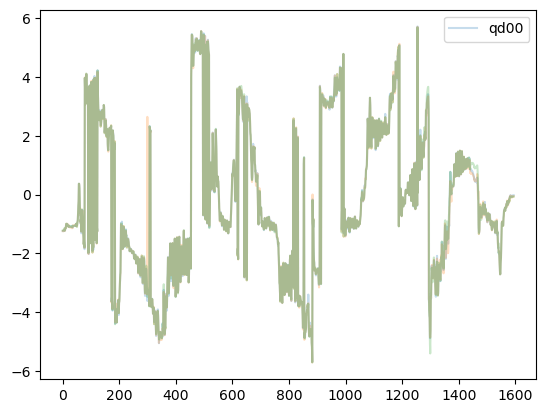

In [32]:
n = 3
plt.figure()
plt.plot(df_qd00[f'{n}_angle'],alpha = 0.25, label="qd00")
plt.plot(df_qs00[f'{n}_angle'], alpha = 0.25)
plt.plot(df_qs08[f'{n}_angle'], alpha = 0.25)
plt.legend()
plt.show()

In [26]:
%time robot = read_csv_comments('./Data/013025/013025_tape_robot.csv') 
C = [(0,1),(0,2),(0,3),(0,4),(0,5),(0,6),(1,2),(2,3),(3,4),(4,5),(5,6),(6,1)]
df = generate_spring_displacement_df(robot, C)

CPU times: user 97.4 ms, sys: 29.7 ms, total: 127 ms
Wall time: 129 ms


no peaks


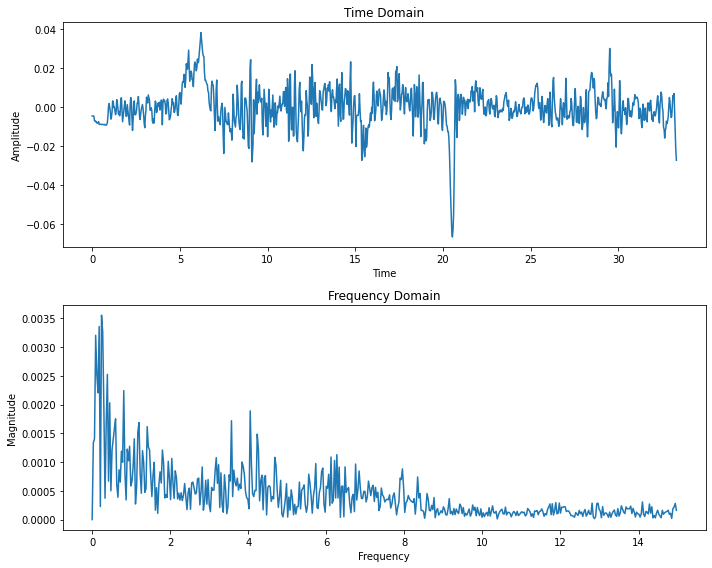

In [193]:
n = 10
plot_fft(np.array(df[df.columns[n]])-np.mean(df[df.columns[n]]))

In [155]:
np.sqrt((robot['1_x']-robot['1_y'])**2+(robot['2_x']-robot['2_y'])**2)

0      0.416151
1      0.416151
2      0.416151
3      0.415968
4      0.415098
         ...   
995    0.076193
996    0.077386
997    0.079822
998    0.083994
999    0.090103
Length: 1000, dtype: float64

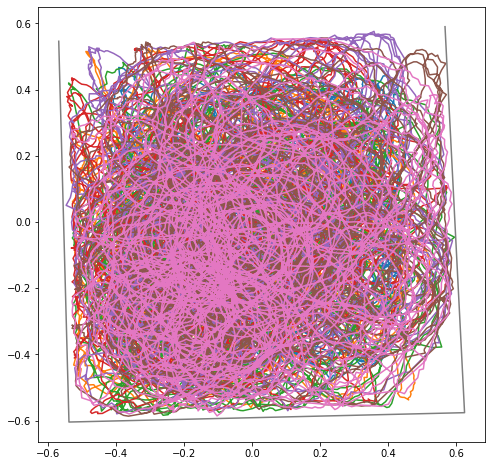

In [27]:
plt.figure(figsize=(8,8))
xcorners = [val[0] for val in robot.attrs['corner_locs']]
ycorners = [val[1] for val in robot.attrs['corner_locs']]
for i in range(7):
    plt.plot(robot[str(i)+'_x'],robot[str(i)+'_y'])
plt.plot(xcorners,ycorners)

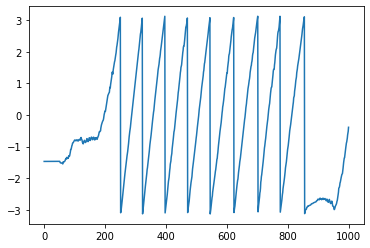

In [23]:
plt.plot(robot['body_angle'])